In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('C:/Users/DENVER/Udacity/machine-learning\projects/toxic-comment-classification/train.csv')#load the dataset
test_data = pd.read_csv('C:/Users/DENVER/Downloads/test.csv/test.csv')
data.head() # have a look at the data


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
data.isnull().any() # check for empty entries

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [5]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
comments_train, comments_test, labels_train, labels_test = train_test_split(data['comment_text'],\
                data[['toxic','severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']], test_size=0.25, random_state=42)



In [62]:
# import keras library for preprocessing

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# turn sentences into bag of wards
max_words = 5000  # maximum number of common wards to be considered
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(comments_train) # fit tokenizer on train data




In [9]:

# turn senteces into sequences 
tokenized_comments_train = tokenizer.texts_to_sequences(comments_train)
tokenized_comments_test = tokenizer.texts_to_sequences(comments_test)
tokenized_test_data = tokenizer.texts_to_sequences(test_data['comment_text'])

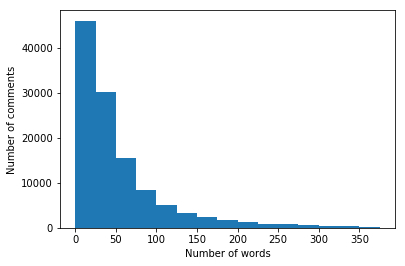

In [10]:
# visualize data
senteces_length = [len(comment) for comment in tokenized_comments_train]

plt.hist(senteces_length, bins=np.arange(0, 400, 25))
plt.ylabel('Number of comments')
plt.xlabel('Number of words')
plt.show()

In [11]:
# turn senteces to the same lenght(maxlen)
comments_length = 150
comments_train = pad_sequences(tokenized_comments_train, maxlen=comments_length )
comments_test = pad_sequences(tokenized_comments_test, maxlen=comments_length)
pad_test_data = pad_sequences(tokenized_test_data, maxlen=comments_length)


In [13]:
# import keras library for architecture
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.layers import Dense, Dropout
from keras.models import Sequential

model = Sequential()
#add embedding layer where max_words is vocabulary size, 150 is length of vectors and 100 is output dimension
model.add(Embedding(max_words, 100, input_length=150))
model.add(Conv1D(filters=10, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=20, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.2))
model.add(Dense(60, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 100)          500000    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 150, 10)           2010      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 75, 10)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 75, 20)            420       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 37, 20)            0         
_________________________________________________________________
global_average_pooling1d_2 ( (None, 20)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
__________

In [50]:
model.compile(optimizer='Adagrad', loss='categorical_crossentropy',  metrics=['categorical_accuracy'])

In [51]:
from keras.callbacks import ModelCheckpoint

# Use model chackpointing to save the model that attains the best validation loss
chackpointer = ModelCheckpoint(filepath='weights.best.h5py')

model.fit(comments_train, labels_train, validation_split=0.1,\
          epochs=5, batch_size=50, callbacks=[chackpointer], verbose=1)

Train on 107710 samples, validate on 11968 samples
Epoch 1/5
107710/107710 [==============================] - 74s 684us/step - loss: 0.2791 - categorical_accuracy: 0.9714 - val_loss: 0.3107 - val_categorical_accuracy: 0.9770
Epoch 2/5
107710/107710 [==============================] - 74s 686us/step - loss: 0.2750 - categorical_accuracy: 0.9639 - val_loss: 0.3094 - val_categorical_accuracy: 0.9591
Epoch 3/5
107710/107710 [==============================] - 73s 675us/step - loss: 0.2728 - categorical_accuracy: 0.9583 - val_loss: 0.3098 - val_categorical_accuracy: 0.9697
Epoch 4/5
107710/107710 [==============================] - 76s 705us/step - loss: 0.2716 - categorical_accuracy: 0.9609 - val_loss: 0.3129 - val_categorical_accuracy: 0.9596
Epoch 5/5
107710/107710 [==============================] - 73s 678us/step - loss: 0.2706 - categorical_accuracy: 0.9564 - val_loss: 0.3114 - val_categorical_accuracy: 0.9619


In [52]:
model.load_weights('weights.best.h5py')

In [53]:
scores = model.evaluate(comments_test,labels_test)
scores

39893/39893 [==============================] - 8s 212us/step


[0.29833658926512607, 0.96332689945903316]

In [54]:
predictions = model.predict(comments_test)

In [55]:
from sklearn.metrics import roc_auc_score
roc_auc_score(labels_test, predictions)

0.72888454437083405

In [24]:
pre = model.predict(pad_test_data)

In [30]:
submission = pd.DataFrame(pre, index=test_data['id'], columns=['toxic', 'severe_toxic',\
                                                               'obscene','threat', 'insult', 'identity_hate'])

In [31]:
submission.to_csv('submission.csv')